In [6]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.base import clone
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from abc import ABC, abstractmethod

# Fetch Boston Dataset
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

# Random Forest Class
class RandomForest(ABC):

    def __init__(self, n_trees=100):
        self.n_trees = n_trees
        self.trees = []

    def __make_bootstraps(self, data):
        dc = {}
        b_size = data.shape[0]
        idx = [i for i in range(b_size)]
        
        for b in range(self.n_trees):
            sidx = np.random.choice(idx, replace=True, size=b_size)
            b_samp = data[sidx, :]
            
            oidx = list(set(idx) - set(sidx))
            o_samp = np.array([])
            if oidx:
                o_samp = data[oidx, :]
                
            dc['boot_'+str(b)] = {'boot': b_samp, 'test': o_samp}
        
        return dc

    def get_params(self, deep=False):
        return {'n_trees': self.n_trees}

    @abstractmethod
    def _make_tree_model(self):
        pass

    def train(self, X_train, y_train):
        training_data = np.concatenate((X_train, y_train.reshape(-1, 1)), axis=1)
        dcBoot = self.__make_bootstraps(training_data)
        
        tree_m = self._make_tree_model()
        for b in dcBoot:
            model = clone(tree_m)
            model.fit(dcBoot[b]['boot'][:, :-1], dcBoot[b]['boot'][:, -1])
            self.trees.append(model)

    def predict(self, X):
        if not self.trees:
            print('You must train the ensemble before making predictions!')
            return None

        predictions = [m.predict(X) for m in self.trees]
        ypred = np.mean(predictions, axis=0)
        
        return ypred

# Concrete implementation of RandomForest using DecisionTreeRegressor
class RandomForestRegressor(RandomForest):

    def _make_tree_model(self):
        return DecisionTreeRegressor()

# Test the Random Forest Regressor
rf = RandomForestRegressor(n_trees=10)
rf.train(X_train, y_train)
y_pred = rf.predict(X_test)

# Display first 5 predictions
print(y_pred)


[22.62 29.4  16.63 22.16 17.35 21.46 18.97 16.03 20.9  20.8  20.45 19.48
  8.92 22.1  20.04 31.1  20.93  8.42 45.17 14.91 25.52 24.32 14.9  26.22
 15.75 14.   20.98 13.55 18.3  20.51 20.78 23.28 33.37 20.36 14.39 16.19
 36.26 20.17 21.23 23.87 20.03 32.   45.93 18.58 21.51 13.32 14.53 24.38
 17.77 30.02 21.34 33.71 16.17 26.88 43.01 22.24 15.28 33.32 22.11 20.96
 23.83 33.59 29.12 19.6  26.89 15.25 11.54 23.64 27.93 15.48 20.24 29.21
 11.29 19.46 22.41  7.76 19.89 47.54 11.53 12.47 21.05 12.02 19.53  9.92
 20.6  26.75 15.55 23.43 23.79 17.6  22.98  7.72 20.65 19.33 22.85 20.35
 37.93 12.43 12.75 12.37 20.68 23.78]


In [13]:
#class for random forest classifier
class RandomForestClassifierCustom(RandomForest):
    #initializer
    def __init__(self,n_trees=100,max_depth: int=None,min_samples_split: int=2,criterion: str='gini',class_weights='balanced'):
        super().__init__(n_trees)
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.criterion = criterion
        self.class_weights = class_weights

    #protected function to obtain the right decision tree
    def _make_tree_model(self):
        return(DecisionTreeClassifier(max_depth = self.max_depth, min_samples_split = self.min_samples_split,criterion = self.criterion,class_weight = self.class_weights))
    #public function to return model parameters
    def get_params(self, deep = False):
         return {'n_trees':self.n_trees,
             'max_depth':self.max_depth,
             'min_samples_split':self.min_samples_split,
             'criterion':self.criterion,
             'class_weights':self.class_weights}
     #train the ensemble
    def fit(self,X_train,y_train,print_metrics=False):
        #call the protected training method
        dcOob = self._train(X_train,y_train)
        #if selected, compute the standard errors and print them
        if print_metrics:
            #initialise metric arrays
            accs = np.array([])
            pres = np.array([])
            recs = np.array([])
            #loop through each bootstrap sample
            for b,m in zip(dcOob,self.trees):
                #compute the predictions on the out-of-bag test set & compute metrics
                if dcOob[b].size:
                    yp = m.predict(dcOob[b][:,:-1])
                    acc = accuracy_score(dcOob[b][:,-1],yp)
                    pre = precision_score(dcOob[b][:,-1],yp,average='weighted')
                    rec = recall_score(dcOob[b][:,-1],yp,average='weighted')
                     #store the error metrics
                    accs = np.concatenate((accs,acc.flatten()))
                    pres = np.concatenate((pres,pre.flatten()))
                    recs = np.concatenate((recs,rec.flatten()))
            #print standard errors
            print("Standard error in accuracy: %.2f" % np.std(accs))
            print("Standard error in precision: %.2f" % np.std(pres))
            print("Standard error in recall: %.2f" % np.std(recs))
 
    #predict from the ensemble
    def predict(self,X):
        #call the protected prediction method
        ypred = self._predict(X)
        #convert the results into integer values & return
        return(np.round(ypred).astype(int))

In [14]:
#load the wine dataset
dfX,sY = load_wine(return_X_y=True, as_frame=True)
#check the dimensions of these data
print('Dimensions of X: ',dfX.shape)
print('Dimensions of y: ',sY.shape)
#what unique classes exist in the label variable?
print('Classes in the label: ',sY.unique())
#what is the frequency of the classes in the dataset?
sY.hist()
plt.show()
#view the first 5 rows of input features
dfX.head(5)
#make a boxplot to view the distribution in these data
dfX.boxplot(figsize=(20,10),rot=45)
plt.show()
## plot the pearson correlation for our input features ##
fig, ax = plt.subplots(figsize = (10, 10))
dfCorr = dfX.corr()
sn.heatmap(dfCorr)
plt.show()
#convert all correlations to positive values
dfCorr = dfCorr.abs()
#loop through rows
for index, sRow in dfCorr.iterrows():
    #get the valid entries
    sCorrs = sRow[sRow.index != index]
    sCorrs = sCorrs[sCorrs > 0.8]
    #print out results
    if not sCorrs.empty:
        print('highly correlated input features: ',index,' & ',sCorrs.index.values)
#create a random forest with balance class weights enabled
rfcC = RandomForestClassifierCustom(class_weights='balanced')
## train the ensemble & view estimates for prediction error ##
rfcC.fit(dfX.values,sY.values,print_metrics=False)
## use k fold cross validation to measure performance ##
scoring_metrics = {'accuracy': make_scorer(accuracy_score),'precision': make_scorer(precision_score, average='weighted'),'recall': make_scorer(recall_score, average='weighted')}
dcScores = cross_validate(rfcC,dfX.values,sY.values,cv=StratifiedKFold(10),scoring=scoring_metrics)
print('Mean Accuracy: %.2f' % np.mean(dcScores['test_accuracy']))
print('Mean Precision: %.2f' % np.mean(dcScores['test_precision']))
print('Mean Recall: %.2f' % np.mean(dcScores['test_recall']))

NameError: name 'load_wine' is not defined

Dimensions of X:  (178, 13)
Dimensions of y:  (178,)
Classes in the label:  [0 1 2]


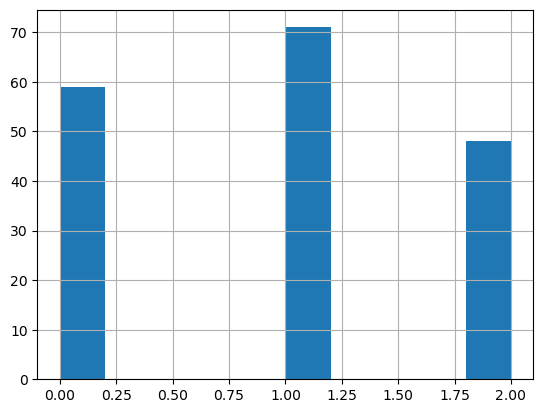

   alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols  \
0    14.23        1.71  2.43               15.6      127.0           2.80   
1    13.20        1.78  2.14               11.2      100.0           2.65   
2    13.16        2.36  2.67               18.6      101.0           2.80   
3    14.37        1.95  2.50               16.8      113.0           3.85   
4    13.24        2.59  2.87               21.0      118.0           2.80   

   flavanoids  nonflavanoid_phenols  proanthocyanins  color_intensity   hue  \
0        3.06                  0.28             2.29             5.64  1.04   
1        2.76                  0.26             1.28             4.38  1.05   
2        3.24                  0.30             2.81             5.68  1.03   
3        3.49                  0.24             2.18             7.80  0.86   
4        2.69                  0.39             1.82             4.32  1.04   

   od280/od315_of_diluted_wines  proline  
0                  

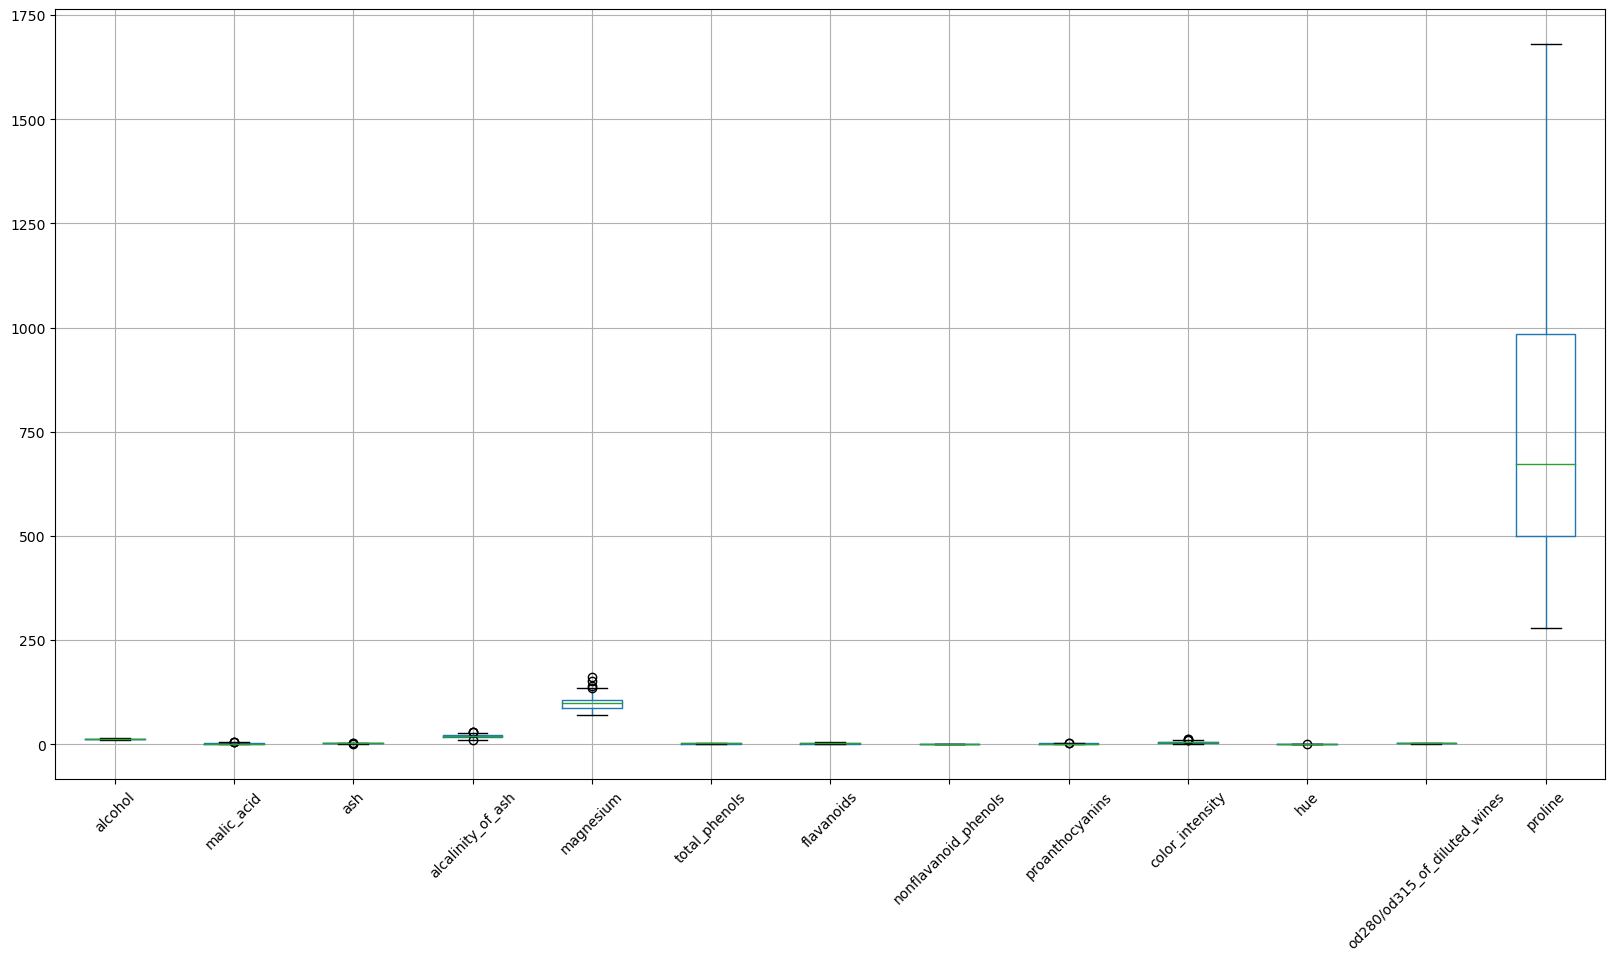

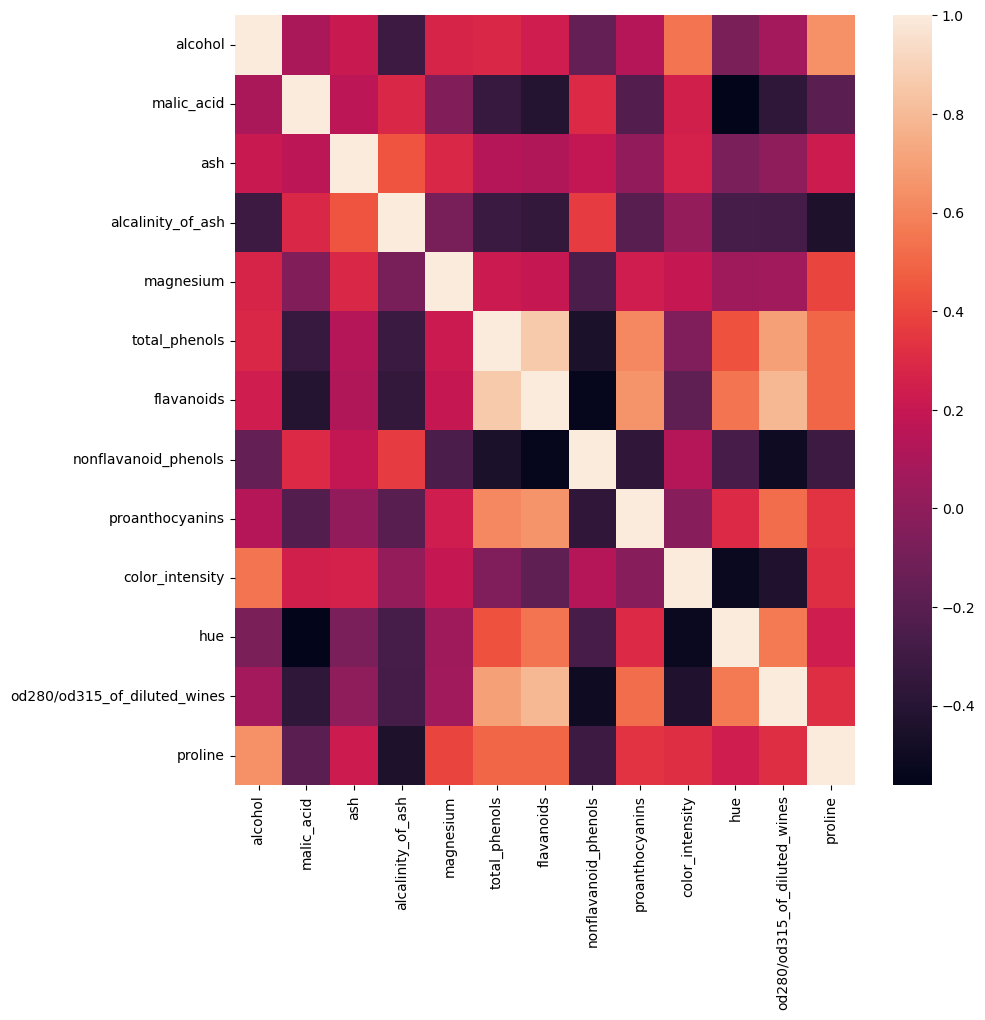

Highly correlated input features:  total_phenols  &  ['flavanoids']
Highly correlated input features:  flavanoids  &  ['total_phenols']


C:\Users\randy\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\randy\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 76, in _cached_call
    return cache[method]
KeyError: 'predict'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\randy\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\randy\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\randy\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 78, in _cached_call
    result = getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\rand

Mean Accuracy: nan
Mean Precision: nan
Mean Recall: nan


C:\Users\randy\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\randy\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 76, in _cached_call
    return cache[method]
KeyError: 'predict'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\randy\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\randy\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\randy\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 78, in _cached_call
    result = getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\rand

In [31]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.base import clone
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, make_scorer
from sklearn.datasets import load_wine
from abc import ABC, abstractmethod

# Fetch Boston Dataset
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

# Random Forest Abstract Class
class RandomForest(ABC):
    def __init__(self, n_trees=100):
        self.n_trees = n_trees
        self.trees = []

    def __make_bootstraps(self, data):
        dc = {}
        b_size = data.shape[0]
        idx = [i for i in range(b_size)]
        for b in range(self.n_trees):
            sidx = np.random.choice(idx, replace=True, size=b_size)
            b_samp = data[sidx, :]
            oidx = list(set(idx) - set(sidx))
            o_samp = np.array([])
            if oidx:
                o_samp = data[oidx, :]
            dc['boot_'+str(b)] = {'boot': b_samp, 'test': o_samp}
        return dc

    def get_params(self, deep=False):
        return {'n_trees': self.n_trees}

    @abstractmethod
    def _make_tree_model(self):
        pass

    def _train(self, X_train, y_train):
        training_data = np.concatenate((X_train, y_train.reshape(-1, 1)), axis=1)
        dcBoot = self.__make_bootstraps(training_data)
        tree_m = self._make_tree_model()
        for b in dcBoot:
            model = clone(tree_m)
            model.fit(dcBoot[b]['boot'][:, :-1], dcBoot[b]['boot'][:, -1])
            self.trees.append(model)
        return {k: v['test'] for k, v in dcBoot.items() if v['test'].size > 0}  # return out-of-bag samples

    def predict(self, X):
        if not self.trees:
            print('You must train the ensemble before making predictions!')
            return None
        predictions = [m.predict(X) for m in self.trees]
        ypred = np.mean(predictions, axis=0)
        return ypred

# Concrete implementation of RandomForest for regression
class RandomForestRegressor(RandomForest):
    def _make_tree_model(self):
        return DecisionTreeRegressor()

# Concrete implementation of RandomForest for classification
class RandomForestClassifierCustom(RandomForest):
    def __init__(self, n_trees=100, max_depth: int=None, min_samples_split: int=2, criterion: str='gini', class_weights='balanced'):
        super().__init__(n_trees)
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.criterion = criterion
        self.class_weights = class_weights

    def _make_tree_model(self):
        return DecisionTreeClassifier(max_depth=self.max_depth, min_samples_split=self.min_samples_split, criterion=self.criterion, class_weight=self.class_weights)

    def get_params(self, deep=False):
        return {'n_trees':self.n_trees, 'max_depth':self.max_depth, 'min_samples_split':self.min_samples_split, 'criterion':self.criterion, 'class_weights':self.class_weights}

    def fit(self, X_train, y_train, print_metrics=False):
    #call the protected training method
        dcOob = self._train(X_train,y_train)
        #if selected, compute the standard errors and print them
        if print_metrics:
            #initialise metric arrays
            accs = np.array([])
#             pres = np.array([])
#             recs = np.array([])
            #loop through each bootstrap sample
            for b,m in zip(dcOob,self.trees):
                #compute the predictions on the out-of-bag test set & compute metrics
                if dcOob[b].size:
                    yp = m.predict(dcOob[b][:,:-1])
                    acc = accuracy_score(dcOob[b][:,-1],yp)
#                     pre = precision_score(dcOob[b][:,-1],yp,average='weighted')
#                     rec = recall_score(dcOob[b][:,-1],yp,average='weighted')
#                      #store the error metrics
#                     accs = np.concatenate((accs,acc.flatten()))
#                     pres = np.concatenate((pres,pre.flatten()))
#                     recs = np.concatenate((recs,rec.flatten()))
#             #print standard errors
#             print("Standard error in accuracy: %.2f" % np.std(accs))
#             print("Standard error in precision: %.2f" % np.std(pres))
#             print("Standard error in recall: %.2f" % np.std(recs))
    def predict(self, X):
        ypred = self._predict(X)
        return np.round(ypred).astype(int)

# Load and analyze the wine dataset
dfX, sY = load_wine(return_X_y=True, as_frame=True)

# Check the dimensions of these data
print('Dimensions of X: ', dfX.shape)
print('Dimensions of y: ', sY.shape)

# What unique classes exist in the label variable?
print('Classes in the label: ', sY.unique())

# What is the frequency of the classes in the dataset?
sY.hist()
plt.show()

# View the first 5 rows of input features
print(dfX.head(5))

# Make a boxplot to view the distribution in these data
dfX.boxplot(figsize=(20,10), rot=45)
plt.show()

# Plot the Pearson correlation for our input features
fig, ax = plt.subplots(figsize=(10, 10))
dfCorr = dfX.corr()
sn.heatmap(dfCorr)
plt.show()

# Convert all correlations to positive values
dfCorr = dfCorr.abs()

# Loop through rows
for index, sRow in dfCorr.iterrows():
    # Get the valid entries
    sCorrs = sRow[sRow.index != index]
    sCorrs = sCorrs[sCorrs > 0.8]
    # Print out results
    if not sCorrs.empty:
        print('Highly correlated input features: ', index, ' & ', sCorrs.index.values)


# Train the RandomForestClassifierCustom on the wine dataset and assess its performance
rfcC = RandomForestClassifierCustom(class_weights='balanced')
rfcC.fit(dfX.values, sY.values, print_metrics=True)
scoring_metrics = {'accuracy': make_scorer(accuracy_score),
                   'precision': make_scorer(precision_score, average='weighted'),
                   'recall': make_scorer(recall_score, average='weighted')}

dcScores = cross_validate(rfcC,dfX.values,sY.values,cv=StratifiedKFold(10),scoring=scoring_metrics)
print('Mean Accuracy: %.2f' % np.mean(dcScores['test_accuracy']))
print('Mean Precision: %.2f' % np.mean(dcScores['test_precision']))
print('Mean Recall: %.2f' % np.mean(dcScores['test_recall']))

In [29]:
## import the scikit-learn models ##
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
#create a random forest with balanced class weights
rfc = RandomForestClassifier(class_weight='balanced')
## use k fold cross validation to measure performance ##
scoring_metrics = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted')}

dcScores = cross_validate(rfc,dfX.values,sY.values,cv=StratifiedKFold(10),scoring=scoring_metrics)
print('Mean Accuracy: %.2f' % np.mean(dcScores['test_accuracy']))
print('Mean Precision: %.2f' % np.mean(dcScores['test_precision']))
print('Mean Recall: %.2f' % np.mean(dcScores['test_recall']))

Mean Accuracy: 0.98
Mean Precision: 0.98
Mean Recall: 0.98


In [36]:
#Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
import seaborn

data = seaborn.load_dataset('iris_csv')
train, test = train_test_split(data, test_size= .3, random_state= 42)
data.head()
print(data)

#Train Test Split
train = data.sample(frac = 0.7, random_state = 1)
test = data.drop(train.index)
y_train = train["species"]
x_train = train.drop("species", axis = 1)
y_test = test["species"]
x_test = test.drop("species", axis = 1)

#Training – Count Posterior
means = train.groupby(["species"]).mean() # Find mean of each class
var = train.groupby(["species"]).var() # Find variance of each class
prior = (train.groupby("species").count() / len(train)).iloc[:,1] # Find prior probability of each class
classes = np.unique(train["species"].tolist()) # Storing all possible classes
#Classification
def Normal(n, mu, var):
    # Function to return pdf of Normal(mu, var) evaluated at x
    sd = np.sqrt(var)
    pdf = (np.e ** (-0.5 * ((n - mu)/sd) ** 2)) / (sd * np.sqrt(2 * np.pi))
    return pdf
def Predict(X):
    Predictions = []

    for i in X.index: # Loop through each instances
        ClassLikelihood = []
        instance = X.loc[i]
        for cls in classes: # Loop through each class
            FeatureLikelihoods = []
            FeatureLikelihoods.append(np.log(prior[cls])) # Append log prior of class 'cls'
            for col in x_train.columns: # Loop through each feature
                data = instance[col]
                mean = means[col].loc[cls] # Find the mean of column 'col' that are in class 'cls'
                variance = var[col].loc[cls] # Find the variance of column 'col' that are in class 'cls'
                Likelihood = Normal(data, mean, variance)
                if Likelihood != 0:
                    Likelihood = np.log(Likelihood) # Find the log-likelihood evaluated at x
                else:
                    Likelihood = 1/len(train)

                FeatureLikelihoods.append(Likelihood)
            TotalLikelihood = sum(FeatureLikelihoods) # Calculate posterior
            ClassLikelihood.append(TotalLikelihood)

        MaxIndex = ClassLikelihood.index(max(ClassLikelihood)) # Find largest posterior position
        Prediction = classes[MaxIndex]
        Predictions.append(Prediction)
    return Predictions
def Accuracy(y, prediction):
    # Function to calculate accuracy
    y = list(y)
    prediction = list(prediction)
    score = 0
    for i, j in zip(y, prediction):
        if i == j:
            score += 1
    return score / len(y)

PredictTrain = Predict(x_train)
PredictTest = Predict(x_test)

print('Training Accuracy: %.4f' % round(Accuracy(y_train, PredictTrain), 5))
print('Testing Accuracy: %.4f' % round(Accuracy(y_test, PredictTest), 5))

ValueError: 'iris_csv' is not one of the example datasets.

In [30]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(x_train, y_train)
SkTrain = clf.predict(x_train) # Predicting on the train set
SkTest = clf.predict(x_test) # Predicting on the test set
print('Training Accuracy: %.4f' % round(Accuracy(y_train, SkTrain), 5))
print('Testing Accuracy: %.4f' % round(Accuracy(y_test, SkTest), 5))

NameError: name 'x_train' is not defined